In [7]:
'''
Diffuse the latent space of VAE model to random noise;
Apply to Gaussian samples as an example.
'''

'\nDiffuse the latent space of VAE model to random noise;\nApply to Gaussian samples as an example.\n'

In [8]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from utils import *

In [9]:
# initialize random seed
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
torch.set_default_tensor_type(FloatTensor)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
sample_dim = 20
batch_size = 40
sample_size = 400
rho = 0.9
num_epochs = 100
learning_rate = 1e-3
z_dim = 10
sample_dir = './results/samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
data = sample_correlated_gaussian(rho, dim=sample_dim, batch_size = sample_size, to_cuda = False)

In [11]:
dataLoader = torch.utils.data.DataLoader(GetLoader(data), batch_size=40, shuffle=True, drop_last=False, num_workers=2)

Epoch[1/100], Step [10/400], Reconst Loss: 1.1121, KL Div: 7.4430
Epoch[2/100], Step [10/400], Reconst Loss: 1.0369, KL Div: 3.7868
Epoch[3/100], Step [10/400], Reconst Loss: 1.1659, KL Div: 2.4865
Epoch[4/100], Step [10/400], Reconst Loss: 1.0528, KL Div: 2.0758
Epoch[5/100], Step [10/400], Reconst Loss: 1.1058, KL Div: 1.5973
Epoch[6/100], Step [10/400], Reconst Loss: 1.0674, KL Div: 1.2222
Epoch[7/100], Step [10/400], Reconst Loss: 1.0421, KL Div: 1.1457
Epoch[8/100], Step [10/400], Reconst Loss: 1.0568, KL Div: 1.0723
Epoch[9/100], Step [10/400], Reconst Loss: 1.1076, KL Div: 0.9064
Epoch[10/100], Step [10/400], Reconst Loss: 1.0710, KL Div: 0.7590
Epoch[11/100], Step [10/400], Reconst Loss: 0.9760, KL Div: 0.6757


/home/wangxu/Documents/projects/LSGM-demo/utils.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(d, d, figsize=(8,8), sharex=True, sharey=True)


Epoch[12/100], Step [10/400], Reconst Loss: 1.0631, KL Div: 0.6523
Epoch[13/100], Step [10/400], Reconst Loss: 0.9831, KL Div: 0.5686
Epoch[14/100], Step [10/400], Reconst Loss: 0.9639, KL Div: 0.4978
Epoch[15/100], Step [10/400], Reconst Loss: 1.0651, KL Div: 0.5014
Epoch[16/100], Step [10/400], Reconst Loss: 0.9377, KL Div: 0.4106
Epoch[17/100], Step [10/400], Reconst Loss: 1.0127, KL Div: 0.4222
Epoch[18/100], Step [10/400], Reconst Loss: 0.9669, KL Div: 0.3518
Epoch[19/100], Step [10/400], Reconst Loss: 1.0423, KL Div: 0.3356
Epoch[20/100], Step [10/400], Reconst Loss: 0.9655, KL Div: 0.3234
Epoch[21/100], Step [10/400], Reconst Loss: 0.9697, KL Div: 0.2884
Epoch[22/100], Step [10/400], Reconst Loss: 1.0031, KL Div: 0.2679
Epoch[23/100], Step [10/400], Reconst Loss: 1.0362, KL Div: 0.2365
Epoch[24/100], Step [10/400], Reconst Loss: 0.9103, KL Div: 0.2239
Epoch[25/100], Step [10/400], Reconst Loss: 0.9820, KL Div: 0.2224
Epoch[26/100], Step [10/400], Reconst Loss: 0.9557, KL Div: 0.

KeyboardInterrupt: 

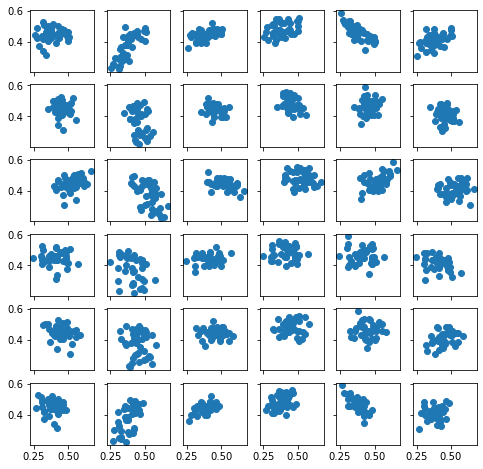

Error in callback <function flush_figures at 0x7f19d5e97200> (for post_execute):


KeyboardInterrupt: 

In [12]:
model = VAE(input_size=sample_dim*2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
torch.multiprocessing.set_start_method('spawn', force=True)
# Start training
for epoch in range(num_epochs):
    for i, x in enumerate(dataLoader):
        # Forward pass
        x = x.to(device).to(torch.float32)
        x_reconst, mu, log_var = model(x)

        # Compute reconstruction loss and kl divergence
        # For KL divergence, see Appendix B in VAE paper or http://yunjey47.tistory.com/43
        # reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        reconst_loss = F.mse_loss(x_reconst, x)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, len(data), reconst_loss.item(), kl_div.item()))

    with torch.no_grad():
        # Save the sampled images
        z = torch.randn(batch_size, z_dim).to(device)
        out = model.decode(z)
        fig = plot_fig(out[:,:sample_dim].cpu(), out[:,sample_dim:].cpu(), d=6)
        plt.savefig(os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))
        # Save the reconstructed images
        out, _, _ = model(x)
        fig = plot_fig(out[:,:sample_dim].cpu(), out[:,sample_dim:].cpu(), d=6)
        plt.savefig(os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))